In [2]:
import keras
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16, DenseNet201
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Dropout, Flatten
from keras.models import Model
from keras.preprocessing import image as image_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras import models, layers, optimizers

In [3]:
import matplotlib.pyplot as plt
plt.style.use('default')

In [4]:
import os
def plot_imgs(directory, top=10):
    all_item_dirs = os.listdir(directory)
    item_files = [os.path.join(directory, file) for file in all_item_dirs][:5]
  
    plt.figure(figsize=(20, 20))
  
    for i, img_path in enumerate(item_files):
        plt.subplot(10, 10, i+1)
    
        img = plt.imread(img_path)
        plt.tight_layout()         
        plt.imshow(img, cmap='gray') 

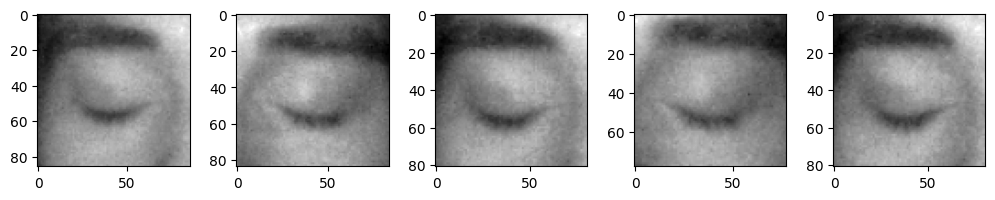

In [5]:
data_path = 'train'

directories = ['/Closed', '/Open']

for j in directories:
    plot_imgs(data_path+j)

In [6]:
batch_size = 128
train_datagen = ImageDataGenerator(horizontal_flip = True, 
                                  rescale = 1./255, 
                                  zoom_range = 0.2, 
                                  validation_split = 0.1)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [7]:
train_data_path = 'train'
test_data_path = 'test'

train_set = train_datagen.flow_from_directory(train_data_path, target_size = (32,32),
                                              batch_size = batch_size, 
                                              color_mode = 'rgb',
                                              class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_data_path, target_size = (32,32),
                                              batch_size = batch_size, 
                                              color_mode = 'rgb',
                                              class_mode = 'categorical')

Found 81675 images belonging to 2 classes.
Found 3223 images belonging to 2 classes.


In [8]:
classes = 2

model = Sequential()

pretrained_model= DenseNet201(include_top=False,
                   input_shape=(32,32,3),
                   pooling='avg',classes=5,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

model.add(pretrained_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(2, activation='softmax'))
print(model.summary())

74836368/74836368 [==============================] - 31s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 1920)              18321984  
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 512)               983552    
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 19,306,562
Trainable params: 984,578
Non-trainable params: 18,321,984
_________________________________________________________________
None


In [9]:
model.compile(loss = 'categorical_crossentropy',optimizer = 'adam' , metrics = ['accuracy'])

In [10]:
model_path="yawn_detectionDensenet.h5"

checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', verbose=1, 
                              save_best_only=True, mode='max')

callbacks_list = [checkpoint]

In [11]:
num_epochs = 25
training_steps=train_set.n//train_set.batch_size
validation_steps =test_set.n//test_set.batch_size

In [12]:
history = model.fit(train_set, epochs=num_epochs, steps_per_epoch=training_steps,validation_data=test_set,
                    validation_steps=validation_steps, callbacks = callbacks_list)

Epoch 1/25
638/638 [==============================] - ETA: 0s - loss: 0.1683 - accuracy: 0.9339
Epoch 1: val_accuracy improved from -inf to 0.87875, saving model to yawn_detectionDensenet.h5
638/638 [==============================] - 119s 159ms/step - loss: 0.1683 - accuracy: 0.9339 - val_loss: 0.2688 - val_accuracy: 0.8788
Epoch 2/25
638/638 [==============================] - ETA: 0s - loss: 0.1097 - accuracy: 0.9581
Epoch 2: val_accuracy did not improve from 0.87875
638/638 [==============================] - 99s 155ms/step - loss: 0.1097 - accuracy: 0.9581 - val_loss: 0.3822 - val_accuracy: 0.8512
Epoch 3/25
638/638 [==============================] - ETA: 0s - loss: 0.0931 - accuracy: 0.9652
Epoch 3: val_accuracy improved from 0.87875 to 0.87906, saving model to yawn_detectionDensenet.h5
638/638 [==============================] - 102s 160ms/step - loss: 0.0931 - accuracy: 0.9652 - val_loss: 0.2926 - val_accuracy: 0.8791
Epoch 4/25
638/638 [==============================] - ETA: 0s - 

In [13]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Giá trị mất mát', fontsize=16)
plt.plot(history.history['loss'], label='Độ mất mát huấn luyện')
plt.plot(history.history['val_loss'], label='Độ mất mát kiểm thử')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Độ chính xác', fontsize=16)
plt.plot(history.history['accuracy'], label='Độ chính xác huấn luyện')
plt.plot(history.history['val_accuracy'], label='Độ chính xác kiểm thử')
plt.legend(loc='lower right')
plt.show()

26/26 [==============================] - 7s 94ms/step
Classification Report:
----------------------
               precision    recall  f1-score   support

      Closed       0.49      0.59      0.53      1566
        Open       0.51      0.41      0.46      1657

    accuracy                           0.50      3223
   macro avg       0.50      0.50      0.50      3223
weighted avg       0.50      0.50      0.49      3223



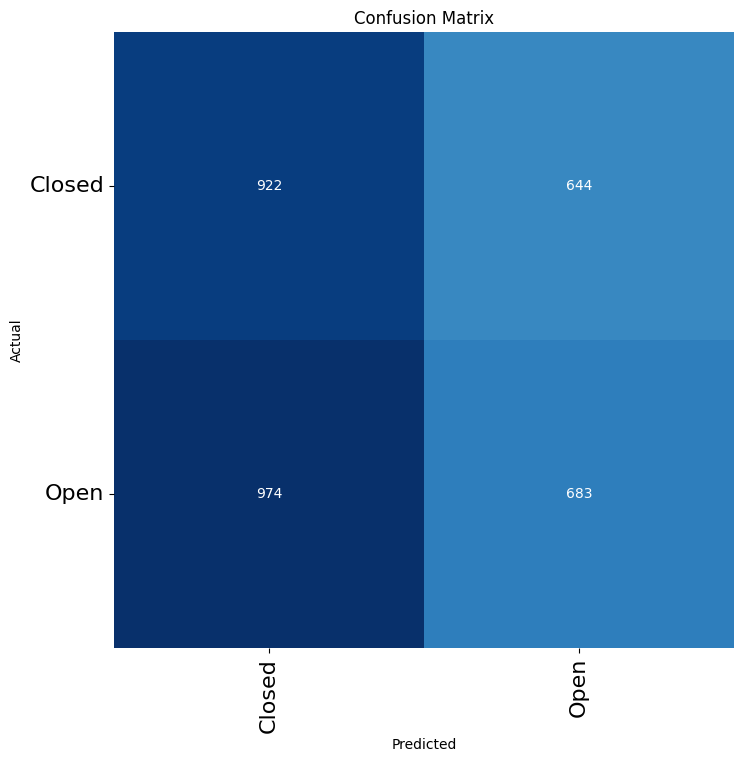

In [14]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns

def cm_cr(test_gen, model):
    preds=model.predict(test_gen)    
    labels=test_gen.labels
    classes=list(test_gen.class_indices.keys()) # ordered lst of class names 
    pred_list=[ ] # will store the predicted classes here
    true_list=[]
    for i, p in enumerate (preds):
        index=np.argmax(p)
        pred_list.append(classes[index])
        true_list.append(classes[labels[i]])
    y_pred=np.array(pred_list)
    y_true=np.array(true_list)
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)
    cm = confusion_matrix(y_true, y_pred )        
    length=len(classes)
    if length<8:
        fig_width=8
        fig_height=8
    else:
        fig_width= int(length * .5)
        fig_height= int(length * .5)
    plt.figure(figsize=(fig_width, fig_height))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
    plt.xticks(np.arange(length)+.5, classes, rotation= 90, fontsize=16)
    plt.yticks(np.arange(length)+.5, classes, rotation=0, fontsize=16)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

cm_cr(test_set, model)

In [15]:
Y_pred = model.predict(test_set)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
qd = confusion_matrix(test_set.classes, y_pred)
ax = sns.heatmap(qd, annot=True, cmap="BuPu",fmt='g')
ax.set_title("Confusion Matrix");
ax.set_xlabel("Predicted")
ax.set_ylabel('Actual');
ax.xaxis.set_ticklabels(["No","Yes"])
ax.yaxis.set_ticklabels(["No","Yes"])
plt.show()

26/26 [==============================] - 2s 83ms/step
Confusion Matrix
